In [1]:
from __future__ import division
import numpy as np
from neuron import h, gui
import matplotlib.pyplot as plt
plt.ion();

### Instantiate model

In [2]:
h.load_file("import3d.hoc")
# for some weird reason NEURON doesn't care about the OS
# and Windows uses the forward slash: '/' as well...
h.load_file("models/L5PCbiophys3.hoc")
h.load_file("models/L5PCtemplate.hoc")
morph_fname = "morphologies/cell1.asc"
L5PC = h.L5PCtemplate(morph_fname)

### Create synapses

In [3]:
# constants used for synapse creation and random activation
syn_dens = 0.1  # /um  (made up number, which is definitely less than real synspe density)
exc_ratio = 0.8
t_stop = 2000  # ms
exc_freq = 1  # Hz
inh_freq = 5  # Hz
seed = 12345
gsyn_exc = 3  # nS  (made up number, which is definitely more than real synspe strength)
gsyn_inh = 5  # nS

In [4]:
# calculate number of synapses to place (based on assumed synapse density)
apical_len = np.sum([x.L for x in L5PC.apical])  # um
basal_len = np.sum([x.L for x in L5PC.basal])  # um
dend_len = apical_len + basal_len
nsyns = int(syn_dens * dend_len)
nsyns_exc = int(nsyns * exc_ratio)
nsyns_exc_apical = int(nsyns_exc * apical_len / dend_len)
nsyns_exc_basal = nsyns_exc - nsyns_exc_apical
nsyns_inh = nsyns - nsyns_exc
nsyns_inh_apical = int(nsyns_inh * apical_len / dend_len)
nsyns_inh_basal = nsyns_inh - nsyns_inh_apical
print("Target number of apical synapses: EXC: %i, INH: %i" % (nsyns_exc_apical, nsyns_inh_apical))
print("Target number of basal synapses: EXC :%i, INH: %i" % (nsyns_exc_basal, nsyns_inh_basal))
# approximate number of synapses per sections
apical_exc_nsyns = [int(nsyns_exc_apical * x.L / apical_len) for x in L5PC.apical]
basal_exc_nsyns = [int(nsyns_exc_basal * x.L / basal_len) for x in L5PC.basal]
apical_inh_nsyns = [int(nsyns_inh_apical * x.L / apical_len) for x in L5PC.apical]
basal_inh_nsyns = [int(nsyns_inh_basal * x.L / basal_len) for x in L5PC.basal]

Target number of apical synapses: EXC: 594, INH: 149
Target number of basal synapses: EXC :411, INH: 103


In [5]:
# setup random number generator for synapse location
rng_pos = h.Random(seed)
rng_pos.uniform(0, 1)
# create apical synapses (and connect them to random number generators)
apical_exc_syns = []
apical_exc_netstims = []
apical_exc_netconns = []
for sec, apical_exc_nsyn in zip(L5PC.apical, apical_exc_nsyns):
    for syn in range(apical_exc_nsyn):
        syn_loc = rng_pos.repick()
        apical_exc_syns.append(h.ProbAMPANMDA_EMS(sec(syn_loc)))
        apical_exc_netstims.append(h.NetStim())
        apical_exc_netstims[-1].number = t_stop / 1000 * exc_freq
        apical_exc_netstims[-1].interval = 1000 / exc_freq  # ms
        apical_exc_netstims[-1].noise = 1  # make it Poisson like
        apical_exc_netconns.append(h.NetCon(apical_exc_netstims[-1], apical_exc_syns[-1]))
        apical_exc_netconns[-1].weight[0] = gsyn_exc
apical_inh_syns = []
apical_inh_netstims = []
apical_inh_netconns = []
for sec, apical_inh_nsyn in zip(L5PC.apical, apical_inh_nsyns):
    for syn in range(apical_inh_nsyn):
        syn_loc = rng_pos.repick()
        apical_inh_syns.append(h.ProbGABAAB_EMS(sec(syn_loc)))
        apical_inh_netstims.append(h.NetStim())
        apical_inh_netstims[-1].number = t_stop / 1000 * inh_freq
        apical_inh_netstims[-1].interval = 1000 / inh_freq  # ms
        apical_inh_netstims[-1].noise = 1  # make it Poisson like
        apical_inh_netconns.append(h.NetCon(apical_inh_netstims[-1], apical_inh_syns[-1]))
        apical_inh_netconns[-1].weight[0] = gsyn_inh
        
# create basal synapses (and connect them to random number generators)
basal_exc_syns = []
basal_exc_netstims = []
basal_exc_netconns = []
for sec, basal_exc_nsyn in zip(L5PC.basal, basal_exc_nsyns):
    for syn in range(basal_exc_nsyn):
        syn_loc = rng_pos.repick()
        basal_exc_syns.append(h.ProbAMPANMDA_EMS(sec(syn_loc)))
        basal_exc_netstims.append(h.NetStim())
        basal_exc_netstims[-1].number = t_stop / 1000 * exc_freq
        basal_exc_netstims[-1].interval = 1000 / exc_freq  # ms
        basal_exc_netstims[-1].noise = 1  # make it Poisson like
        basal_exc_netconns.append(h.NetCon(basal_exc_netstims[-1], basal_exc_syns[-1]))
        basal_exc_netconns[-1].weight[0] = gsyn_exc
basal_inh_syns = []
basal_inh_netstims = []
basal_inh_netconns = []
for sec, basal_inh_nsyn in zip(L5PC.basal, basal_inh_nsyns):
    for syn in range(basal_inh_nsyn):
        syn_loc = rng_pos.repick()
        basal_inh_syns.append(h.ProbGABAAB_EMS(sec(syn_loc)))
        basal_inh_netstims.append(h.NetStim())
        basal_inh_netstims[-1].number = t_stop / 1000 * inh_freq
        basal_inh_netstims[-1].interval = 1000 / inh_freq  # ms
        basal_inh_netstims[-1].noise = 1  # make it Poisson like
        basal_inh_netconns.append(h.NetCon(basal_inh_netstims[-1], basal_inh_syns[-1]))
        basal_inh_netconns[-1].weight[0] = gsyn_inh

### Run sim, plot results

In [6]:
# recording
t = h.Vector()
t.record(h._ref_t)
soma_v = h.Vector()
soma_v.record(L5PC.soma[0](0.5)._ref_v)
# run
h.v_init = -80
h.tstop = t_stop
h.celsius = 37
h.run();

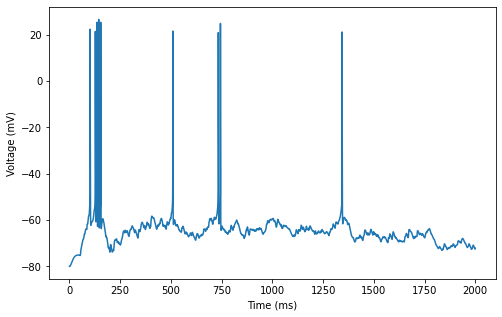

In [7]:
# plot results
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(t, soma_v)
ax.set_xlabel("Time (ms)");
ax.set_ylabel("Voltage (mV)");

### 